<a href="https://colab.research.google.com/github/AdamVinestock/NLP/blob/main/NLP_Relation_Classidication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a DNN for Relation Classification

In this notebook we will build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
More info can be read in the documentation at [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link.


Additional packages:

In [1]:
# !pip install --q
!pip install --q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.9 MB/s eta 0:00:00


Imports:

In [2]:
# general
import os
import random
import warnings
from typing import List,Tuple

# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

# Others

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Set random SEEDs:

In [3]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(42)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Set GPU:

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Dataset


The dataset we will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contains only train and test split, so we can split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [5]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Receiving objects: 100% (71/71), 11.28 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (29/29), done.


## Task #1

We will write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [6]:
def read_data(filepath:str) -> List[Tuple[str,str]]:
    data = []
    with open(filepath, 'r') as file:
      lines = file.readlines()
      for i in range(0, len(lines), 4):
          line = lines[i].strip()
          start_index = line.find('"')    # Find the index of the first occurrence of "
          end_index = line.rfind('"')     # Find the index of the last occurrence of "
          sentence = line[start_index+1:end_index]

          # Remove e1/e2 from labels
          label = lines[i+1].strip()
          if label != 'Other':
            label = label[:-7]

          data.append((sentence, label))
    return data

train = read_data("/content/nlp-course/TRAIN_FILE.TXT")
test = read_data("/content/nlp-course/TEST_FILE_FULL.TXT")

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))

Number of train sentences: 8000
Number of test sentences: 2717


`Pytorch` requires the labels to be integers.

Therefore we will create a mapper (dictionary) from the string labels to integers (starting zero), and a dictionary from labels to integers.

In [7]:
def create_label_mapper(data):
    label_set = set()
    for (sen, lbl) in data:
        label_set.add(lbl)
    label2id = {label: i for i, label in enumerate(sorted(label_set))}
    id2label = {i: label for i, label in enumerate(sorted(label_set))}
    return id2label, label2id

id2label, label2id = create_label_mapper(train)

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

id2label: 
 {0: 'Cause-Effect', 1: 'Component-Whole', 2: 'Content-Container', 3: 'Entity-Destination', 4: 'Entity-Origin', 5: 'Instrument-Agency', 6: 'Member-Collection', 7: 'Message-Topic', 8: 'Other', 9: 'Product-Producer'}


<br>

Now we will plot the distribution of labels in each dataset.

In [8]:
labels = list(label2id.keys())

def plot_label_distribution(train_dataset, test_dataset, label2id):
    # Create a dictionary to store the count of each label
    train_lbl_c = {lbl: 0 for lbl in label2id.keys()}
    test_lbl_c = {lbl: 0 for lbl in label2id.keys()}

    for _, label in train_dataset:
        train_lbl_c[label] += 1

    for _, label in test_dataset:
        test_lbl_c[label] += 1

    # Set up the plot
    fig, ax = plt.subplots(figsize=(16, 6))
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    train_positions = range(len(train_lbl_c.keys()))
    test_positions = [x + bar_width for x in train_positions]

    # Create the bar plots for train and test datasets
    ax.bar(train_positions, train_lbl_c.values(), width=bar_width, label='Train Dataset')
    ax.bar(test_positions, test_lbl_c.values(), width=bar_width, label='Test Dataset')

    # Set the titles and axis names
    ax.set_title("Label Distribution for Train and Test Datasets", fontsize=20)
    ax.set_xlabel("Label", fontsize=16)
    ax.set_ylabel("Count", fontsize=16)

    # Set the x-axis tick positions and labels with vertical rotation
    plt.xticks(rotation=45)
    plt.xticks([r + bar_width / 2 for r in range(len(labels))], label2id.keys())

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

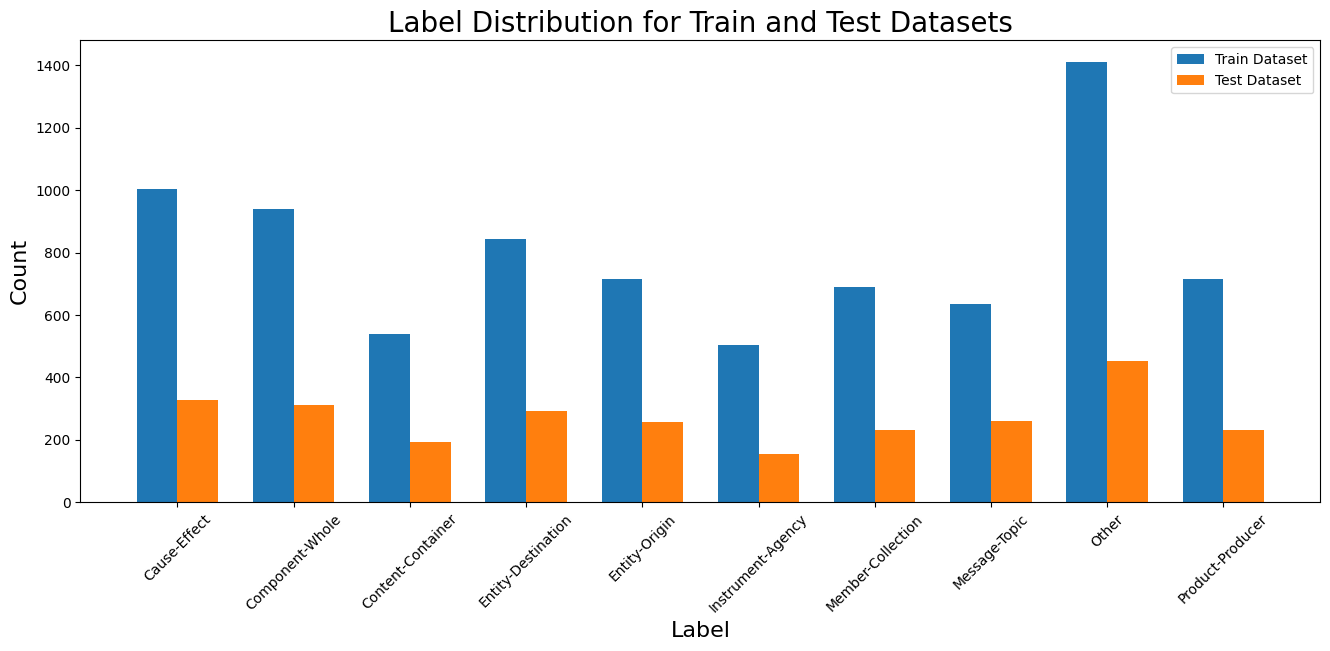

In [9]:
plot_label_distribution(train, test, label2id)

In [10]:
# Spliting the train_set into Train and Dev sets

def split_train_dev(train_set, dev_set_size):
    sentences, labels = zip(*train_set)                   # Split test_set into sentences and labels
    sentences_train, sentences_dev, labels_train, labels_dev = train_test_split(sentences, labels, test_size=dev_set_size, random_state=42)
    train_set = list(zip(sentences_train, labels_train))  # Combine train_set sentences and labels
    dev_set = list(zip(sentences_dev, labels_dev))        # Combine dev_set sentences and labels
    return train_set, dev_set

dev_set_size = 0.2    # Set the desired proportion for the dev_set (e.g., 0.2 for 20%)
train,dev = split_train_dev(train, dev_set_size)


## Task #2

Now we will download the relevant BERT tokenizer.
In this case we'll use `bert-base-uncased` .


In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We will write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregates the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, label2id):
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence, label = self.data[index]
        tokens = self.tokenizer.tokenize(sentence)
        tokens = ['[CLS]'] + tokens                       # Add [CLS] token at the beginning
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        label_id = self.label2id[label]
        attention_mask = torch.ones(len(input_ids))
        return input_ids, attention_mask, label_id

def prepare_data(data, tokenizer, label2id, batch_size=8):
    dataset = CustomDataset(data, tokenizer, label2id)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
    return data_loader

def pad_collate(batch):
    sentences, attention_masks, labels = zip(*batch)
    padded_sentences = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True)  # Pad sentences to the length of the longest sentence in the batch
    padded_attention_masks = pad_sequence([a for a in attention_masks], batch_first=True)    # Pad attention masks
    return padded_sentences, padded_attention_masks, torch.tensor(labels)

train_sequences = prepare_data(train, tokenizer, label2id, batch_size=16)
dev_sequences = prepare_data(dev, tokenizer, label2id, batch_size=16)
test_sequences = prepare_data(test, tokenizer, label2id, batch_size=16)

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


We'll download the relevant BERT model using `bert-base-uncased` .

In [13]:
num_classes= max(id2label.keys())+1
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



We will write a function `get_parameters` that gets the model as an input and returns the top (final) layer of the model for a `torch` optimizer.

Note: these links are helpful [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [14]:
from transformers import BertForSequenceClassification

def get_parameters(params):
    # Extract the top layer parameters for optimizer (layer 11 - pooler - classifier)
    top_layer_params = []
    for name, param in params:
        if '11' in name or 'pooler' in name or 'classifier' in name:
            top_layer_params.append(param)
        else:
            param.requires_grad = False
    return top_layer_params

# Get the named parameters of the model
all_model_params = model.named_parameters()

# Get the parameters from layer 11 and beyond (layer 11, pooler, classifier)
top_layer_params = get_parameters(all_model_params)

Defining the optimizer:

- We will sse the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- A learning rate of 0.0001.
- We send only the top module of the model to the optimizer.


In [15]:
# Define the optimizer
optimizer = optim.Adam(top_layer_params, lr=0.0001)

## Task #4

Let's create the trainig function!


1. We will write a training function, which takes the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs using [tqdm](https://github.com/tqdm/tqdm) to mark the iteration and progress.



In [16]:
def train_loop(model, train_loader, dev_loader, optimizer, num_epochs):
    criterion = nn.CrossEntropyLoss()
    model.to(DEVICE)

    for epoch in tqdm(range(num_epochs), desc=f"Training", unit="Epoch"):  # desc=f"Epoch {epoch+1}/{num_epochs}"
        model.train()
        train_loss = 0.0
        train_correct = 0

        # Training loop
        for inputs, attention_mask, labels in train_loader:
            inputs = inputs.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, attention_mask=attention_mask).logits
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # Evaluation on the dev set
        model.eval()
        dev_loss = 0.0
        dev_correct = 0
        with torch.no_grad():
            for inputs, attention_mask, labels in dev_loader:
                inputs = inputs.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(inputs, attention_mask=attention_mask).logits
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                dev_correct += (predicted == labels).sum().item()
                dev_loss += loss.item()

        # Calculate average dev loss and accuracy
        dev_loss /= len(dev_loader.dataset)
        dev_accuracy = dev_correct / len(dev_loader.dataset)

        # Print epoch statistics
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
        print(f"Dev Loss: {dev_loss:.4f} | Dev Accuracy: {dev_accuracy*100:.2f}%")
        print("--------------------------------------------------")


In [17]:
train_loop(model, train_sequences, dev_sequences, optimizer, 4)

Training:  25%|██▌       | 1/4 [00:40<02:00, 40.26s/Epoch]


Epoch 1/4:
Train Loss: 0.1011 | Train Accuracy: 42.88%
Dev Loss: 0.0595 | Dev Accuracy: 67.06%
--------------------------------------------------


Training:  50%|█████     | 2/4 [01:13<01:12, 36.31s/Epoch]


Epoch 2/4:
Train Loss: 0.0556 | Train Accuracy: 68.56%
Dev Loss: 0.0459 | Dev Accuracy: 74.56%
--------------------------------------------------


Training:  75%|███████▌  | 3/4 [01:48<00:35, 35.59s/Epoch]


Epoch 3/4:
Train Loss: 0.0446 | Train Accuracy: 74.62%
Dev Loss: 0.0423 | Dev Accuracy: 76.88%
--------------------------------------------------


Training: 100%|██████████| 4/4 [02:24<00:00, 36.10s/Epoch]


Epoch 4/4:
Train Loss: 0.0391 | Train Accuracy: 76.91%
Dev Loss: 0.0407 | Dev Accuracy: 77.75%
--------------------------------------------------


## Task #5

We will write an evaluation loop on a trained model, using the test dataset.
This function will perform an evaluation over a model with a dataset, calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Input: model, data

Output: Report, Confusion matrix

+--------------------+-------------+----------+--------+-----------+
|                    |   Precision |   Recall |     F1 |   Support |
|--------------------+-------------+----------+--------+-----------|
| Cause-Effect       |      0.8375 |   0.9116 | 0.8730 |  328.0000 |
| Component-Whole    |      0.8129 |   0.8077 | 0.8103 |  312.0000 |
| Content-Container  |      0.8068 |   0.8698 | 0.8371 |  192.0000 |
| Entity-Destination |      0.8273 |   0.9349 | 0.8778 |  292.0000 |
| Entity-Origin      |      0.8030 |   0.8372 | 0.8197 |  258.0000 |
| Instrument-Agency  |      0.7000 |   0.7179 | 0.7089 |  156.0000 |
| Member-Collection  |      0.7840 |   0.8412 | 0.8116 |  233.0000 |
| Message-Topic      |      0.7918 |   0.8889 | 0.8375 |  261.0000 |
| Other              |      0.5327 |   0.3943 | 0.4532 |  454.0000 |
| Product-Producer   |      0.8244 |   0.7316 | 0.7752 |  231.0000 |
+--------------------+-------------+----------+--------+-----------+
Macro average F1: 0.7804


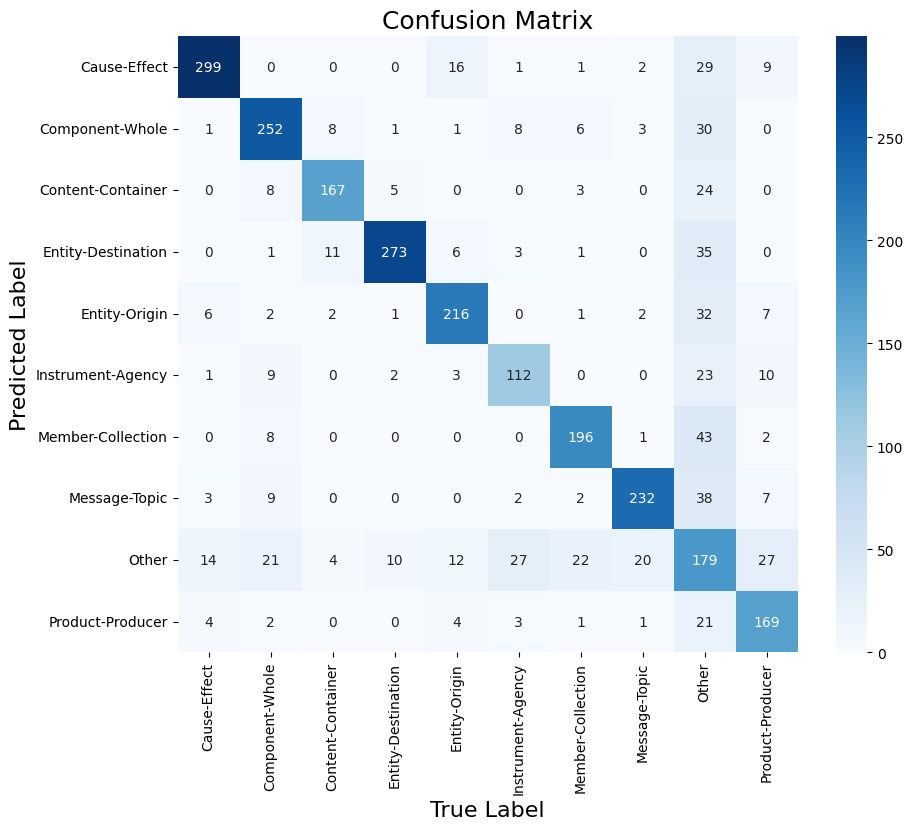

In [18]:
def evaluate(model, test_data, label_names):
    model.to(DEVICE)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, attention_mask, labels in test_data:
            inputs = inputs.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs, attention_mask=attention_mask).logits
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0)
    precision = [report[label]['precision'] for label in label_names]
    recall = [report[label]['recall'] for label in label_names]
    f1 = [report[label]['f1-score'] for label in label_names]
    support = [report[label]['support'] for label in label_names]

    # Display metrics in a table
    df = pd.DataFrame(data={'Precision': precision, 'Recall': recall, 'F1': f1, 'Support': support}, index=label_names)
    print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

    print(f"Macro average F1: {report['macro avg']['f1-score']:.4f}")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred).T # Convert to true labels in columns, predictions in rows
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
    plt.xlabel("True Label", size=16)
    plt.ylabel("Predicted Label", size=16)
    plt.title("Confusion Matrix", size=18)
    plt.show()

    # Save report to a CSV file
    df.to_csv("part5.csv", index=True)


label_names = list(label2id.keys())
evaluate(model, test_sequences, label_names)

<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data loader and a new model.

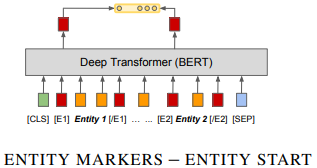

In [19]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(42)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

The new methods require the usage of special tokens.

In [20]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

new_tokens = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mtb_tokenizer.add_special_tokens({'additional_special_tokens': new_tokens})

4

In [21]:
mtb_tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]', 'additional_special_tokens': ['<e1>', '</e1>', '<e2>', '</e2>']}, clean_up_tokenization_spaces=True)

We will create a new dataloader that extracts the entity markers from the dataset and returns their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a tuple with the indexes of the start entities)

In [22]:
class MTBRCDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, label2id):
      super(MTBRCDataset, self).__init__()
      self.data = data
      self.tokenizer = tokenizer
      self.label2id = label2id

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      sentence, label = self.data[index]
      tokens = self.tokenizer.tokenize(sentence)
      input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      label_id = self.label2id[label]

      e1_index = input_ids.index(mtb_tokenizer.convert_tokens_to_ids(E1_START))   # Find index of <e1> token
      e2_index = input_ids.index(mtb_tokenizer.convert_tokens_to_ids(E2_START))   # Find index of <e2> token
      start_entities = (e1_index, e2_index)

      attention_mask = torch.ones(len(input_ids))

      return input_ids, attention_mask, label_id, start_entities

def mtb_pad_collate(batch):
    sentences, attention_masks, labels, entities = zip(*batch)
    padded_sentences = pad_sequence([torch.tensor(s) for s in sentences], batch_first=True) # Pad sentences to the length of the longest sentence in the batch
    padded_attention_masks = pad_sequence([a for a in attention_masks], batch_first=True)  # Pad attention masks
    return padded_sentences, padded_attention_masks, torch.tensor(labels), torch.tensor(entities)

In [23]:
def prepare_data_MTB(data, tokenizer, label2id, batch_size=8):
    dataset = MTBRCDataset(data, tokenizer, label2id)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=mtb_pad_collate)
    return data_loader

mtb_train_dl = prepare_data_MTB(train, mtb_tokenizer, label2id, 8)
mtb_dev_dl = prepare_data_MTB(dev, mtb_tokenizer, label2id, 8)
mtb_test_dl = prepare_data_MTB(test, mtb_tokenizer, label2id, 8)

In [24]:
print(len(mtb_train_dl),len(mtb_dev_dl),len(mtb_test_dl))

800 200 340


Now we create a new model that uses the "entity markers - Entity start" method.

In [25]:
class MTB(nn.Module):

    def __init__(self, base_model_name, output_size):
      super(MTB, self).__init__()
      self.model = BertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_classes)
      hidden_size = self.model.config.hidden_size
      self.pooler = nn.Linear(hidden_size * 2, hidden_size)
      self.dropout = nn.Dropout(0.1)
      self.classifier = nn.Linear(hidden_size, output_size)

    def resize_token_embeddings(self, new_num_tokens):
        old_num_tokens = self.model.config.vocab_size
        if old_num_tokens != new_num_tokens:
            self.model.resize_token_embeddings(new_num_tokens)

    def forward(self, input_ids, attention_mask, start_entities):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)   # outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states
        last_hidden_state = hidden_states[-1]                                  # Last layer's hidden states

        batch_size = last_hidden_state.size(0)
        entity_embeddings_e1 = last_hidden_state[torch.arange(batch_size), start_entities[:, 0], :]              # Shape: (batch_size, hidden_size)
        entity_embeddings_e2 = last_hidden_state[torch.arange(batch_size), start_entities[:, 1], :]              # Shape: (batch_size, hidden_size)
        pooled_output = torch.cat([entity_embeddings_e1.unsqueeze(1), entity_embeddings_e2.unsqueeze(1)], dim=1) # Shape: (batch_size, 2, hidden_size)
        pooled_output = pooled_output.view(batch_size, -1)           # Reshape to (batch_size, 2*hidden_size)

        pooled_output = self.pooler(pooled_output)                   # Shape: (batch_size, hidden_size)
        pooled_output = self.dropout(pooled_output)
        output = self.classifier(pooled_output)                      # Shape: (batch_size, num_labels)
        return output

mtb_num_classes = max(id2label.keys())+1
model_mtb = MTB('bert-base-uncased', mtb_num_classes).to(DEVICE)
model_mtb.resize_token_embeddings(len(mtb_tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
def mtb_get_parameters(params):
    # Extract the top layer parameters for optimizer (layer 11 - pooler - classifier)
    top_layer_params = []
    for name, param in params:
        if '11' in name or 'pooler' in name or 'classifier' in name:
            top_layer_params.append(param)
        else:
            param.requires_grad = False
    return top_layer_params

# Get the named parameters of the model
all_mtb_model_params = model_mtb.named_parameters()

# Get the top layer parameters
mtb_top_layer_params = get_parameters(all_mtb_model_params)
mtb_optimizer = optim.Adam(mtb_top_layer_params, lr=0.0001) # 0.00003

**Training and Evaluation**

We will use the new dataloader and model to train the new model similarly to task 4.
Then we will use the new dataloader and model to evaluate the new model similarly to task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


In [27]:
def mtb_train_loop(model, train_loader, dev_loader, optimizer, num_epochs):
    criterion = nn.CrossEntropyLoss()
    model.to(DEVICE)

    for epoch in tqdm(range(num_epochs), desc=f"Training", unit="Epoch"):
        model.train()
        train_loss = 0.0
        train_correct = 0

        # Training loop
        for inputs, attention_mask, labels, start_entities in train_loader:
            inputs = inputs.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)
            start_entities = start_entities.to(DEVICE)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs, attention_mask, start_entities)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

        # Calculate average training loss and accuracy
        train_loss /= len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        # Evaluation on the dev set
        model.eval()
        dev_loss = 0.0
        dev_correct = 0
        with torch.no_grad():
            for inputs, attention_mask, labels, start_entities in dev_loader:
                inputs = inputs.to(DEVICE)
                attention_mask = attention_mask.to(DEVICE)
                labels = labels.to(DEVICE)
                start_entities = start_entities.to(DEVICE)
                outputs = model(inputs, attention_mask, start_entities) #.logits
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                dev_correct += (predicted == labels).sum().item()
                dev_loss += loss.item()

        # Calculate average dev loss and accuracy
        dev_loss /= len(dev_loader.dataset)
        dev_accuracy = dev_correct / len(dev_loader.dataset)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy*100:.2f}%")
        print(f"Dev Loss: {dev_loss:.4f} | Dev Accuracy: {dev_accuracy*100:.2f}%")
        print("--------------------------------------------------")

In [28]:
mtb_train_loop(model_mtb, mtb_train_dl, mtb_dev_dl, mtb_optimizer, 4)

Training:  25%|██▌       | 1/4 [00:30<01:30, 30.31s/Epoch]

Epoch 1/4:
Train Loss: 0.1539 | Train Accuracy: 57.22%
Dev Loss: 0.1041 | Dev Accuracy: 71.19%
--------------------------------------------------


Training:  50%|█████     | 2/4 [01:00<01:00, 30.32s/Epoch]

Epoch 2/4:
Train Loss: 0.0997 | Train Accuracy: 71.70%
Dev Loss: 0.0941 | Dev Accuracy: 75.00%
--------------------------------------------------


Training:  75%|███████▌  | 3/4 [01:30<00:30, 30.20s/Epoch]

Epoch 3/4:
Train Loss: 0.0835 | Train Accuracy: 75.94%
Dev Loss: 0.0904 | Dev Accuracy: 75.56%
--------------------------------------------------


Training: 100%|██████████| 4/4 [02:00<00:00, 30.20s/Epoch]

Epoch 4/4:
Train Loss: 0.0715 | Train Accuracy: 79.44%
Dev Loss: 0.0863 | Dev Accuracy: 76.81%
--------------------------------------------------


+--------------------+-------------+----------+--------+-----------+
|                    |   Precision |   Recall |     F1 |   Support |
|--------------------+-------------+----------+--------+-----------|
| Cause-Effect       |      0.8919 |   0.9055 | 0.8986 |  328.0000 |
| Component-Whole    |      0.7567 |   0.8173 | 0.7858 |  312.0000 |
| Content-Container  |      0.7689 |   0.9010 | 0.8297 |  192.0000 |
| Entity-Destination |      0.8750 |   0.9110 | 0.8926 |  292.0000 |
| Entity-Origin      |      0.7810 |   0.8295 | 0.8045 |  258.0000 |
| Instrument-Agency  |      0.7241 |   0.6731 | 0.6977 |  156.0000 |
| Member-Collection  |      0.8249 |   0.7682 | 0.7956 |  233.0000 |
| Message-Topic      |      0.8000 |   0.8889 | 0.8421 |  261.0000 |
| Other              |      0.5571 |   0.4515 | 0.4988 |  454.0000 |
| Product-Producer   |      0.8170 |   0.7922 | 0.8044 |  231.0000 |
+--------------------+-------------+----------+--------+-----------+
Macro average F1: 0.7850


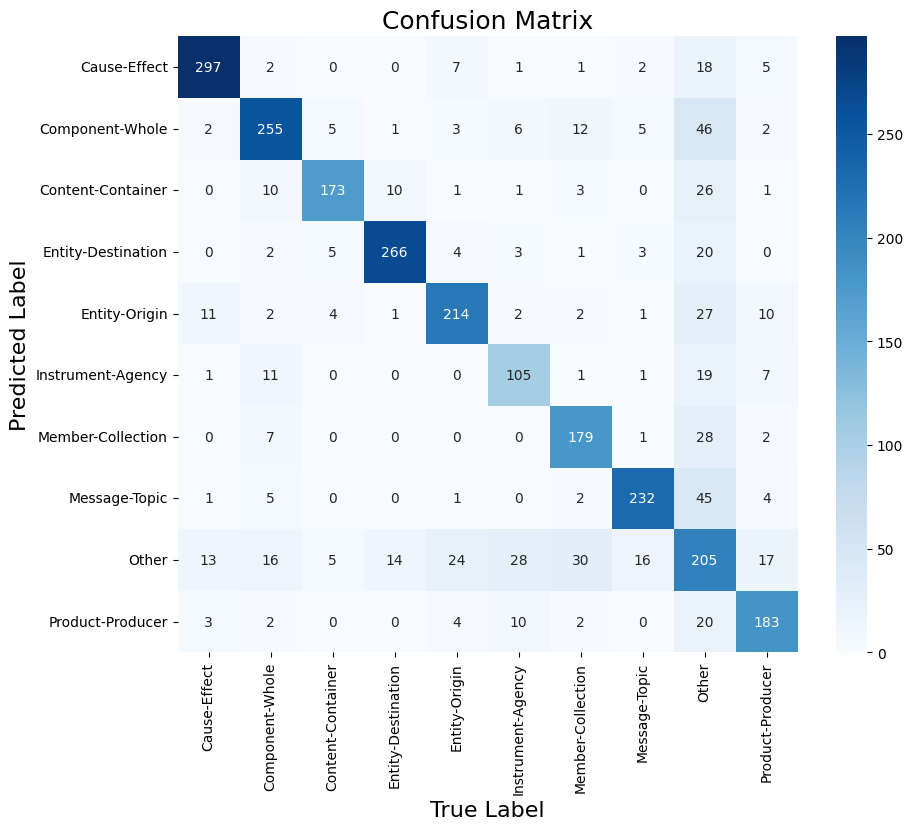

In [29]:
def mtb_evaluate(model, test_data, label_names):
    model.to(DEVICE)
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, attention_mask, labels, start_entities in test_data:
            inputs = inputs.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)
            start_entities = start_entities.to(DEVICE)

            outputs = model(inputs, attention_mask, start_entities)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0)
    precision = [report[label]['precision'] for label in label_names]
    recall = [report[label]['recall'] for label in label_names]
    f1 = [report[label]['f1-score'] for label in label_names]
    support = [report[label]['support'] for label in label_names]

    # Display metrics in a table
    df_mtb = pd.DataFrame(data={'Precision': precision, 'Recall': recall, 'F1': f1, 'Support': support}, index=label_names)
    print(tabulate(df_mtb, headers='keys', tablefmt='psql',floatfmt=".4f"))

    print(f"Macro average F1: {report['macro avg']['f1-score']:.4f}")

    # Display confusion matrix
    cm = confusion_matrix(y_true, y_pred).T # Convert to true labels in columns, predictions in rows
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
    plt.xlabel("True Label", size=16)
    plt.ylabel("Predicted Label", size=16)
    plt.title("Confusion Matrix", size=18)
    plt.show()

    # Save report to a CSV file
    df_mtb.to_csv("209795624_312332372_part6.csv", index=True)


mtb_label_names = list(label2id.keys())
mtb_evaluate(model_mtb, mtb_test_dl, mtb_label_names)

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

This will be done by getting the dataset from kaggle and creating an inference pipeline for the Sentence similarity.


Optional: Clear GPU space if needed

In [30]:
torch.cuda.empty_cache()

Set all the relavant random seeds to 111

In [31]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(111)

We will download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [32]:
!git clone https://github.com/saharmilis/runi-nlp.git

Cloning into 'runi-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 3.61 MiB | 3.69 MiB/s, done.
Resolving deltas: 100% (2/2), done.


Then we download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here is the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [33]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=1ce2ec48714d517428e240735a9d2f2e8d8c6758e53cbd87b653c35d62c5eb17
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [34]:
from sentence_transformers import SentenceTransformer, util
model3 = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

We will run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [35]:
df_t7 = pd.DataFrame(columns=['ID','LABEL_TRUE','LABEL_PRED'])

# Load the data
df = pd.read_csv('/content/runi-nlp/kaggle/nlp_2023_train.csv')

threshold = 0.8
sentences1 = []
sentences2 = []
# Iterate over each row
for index, row in df.iterrows():
  # Extract the sentences
  sentences1.append(row['text1'])
  sentences2.append(row['text2'])

  if index == 4999:
    break

embedding_1 = model3.encode(sentences1, convert_to_tensor=True)
embedding_2 = model3.encode(sentences2, convert_to_tensor=True)


cos_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
cosine_similarities = cos_sim(embedding_1, embedding_2)

predictions = (cosine_similarities > threshold).float().cpu()

pred_column = pd.Series(predictions.numpy())
ID_column = pd.Series(range(5000))
df['Similarity'] = df['Similarity'].apply(lambda x: 1 if x > 0.5 else 0)

df_t7['LABEL_PRED'] = pred_column
df_t7['LABEL_TRUE'] = df['Similarity'].iloc[0:5000]
df_t7['ID'] = ID_column

df_t7 = df_t7.astype(int)

We will print a classification report (using a simple SK-learn classification report)

In [36]:
classification_r = sklearn.metrics.classification_report(df_t7['LABEL_TRUE'], df_t7['LABEL_PRED'])
print(classification_r)

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      3114
           1       0.73      0.77      0.75      1886

    accuracy                           0.81      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.81      0.81      0.81      5000



In [37]:
# Save the DataFrame to a CSV file
df_t7.to_csv('part7.csv', index=False)

In [38]:
print(df_t7)

        ID  LABEL_TRUE  LABEL_PRED
0        0           0           0
1        1           0           0
2        2           0           0
3        3           0           0
4        4           0           0
...    ...         ...         ...
4995  4995           0           0
4996  4996           0           0
4997  4997           0           0
4998  4998           1           1
4999  4999           0           0

[5000 rows x 3 columns]
